In [24]:
# importando as bibliotecas

import numpy as np
import control as ct
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

# 1  Modelagem do sistema

In [25]:
# Parâmetros 

m = 1     # kilograma
m1 = 1    # kilograma
m2 = 1    # kilograma
l1 = 0.05 # metros
l2 = 0.05 # metros
g = 9.81  # m/s^2
f0 = 0.01
f1 = 0.007
f2 = 0.007
J1 = 0.00083 
J2 = 0.00083
Ts = 0.01
l = 0.45

# Simplificação
A01 =-J1*J2*(m+m1+m2)-2*m2*l2*l2*J1*(m+m1+(1/2)*m2)-J2*l1*l1*(m*m1+2*m*m2-m1*m2-2*m2*m2)
A02 =  -2*l1*l1*l2*l2*m2*(m*m1-3/2 *m1*m2 -m2*m2)
A0 = A01 + A02
A1 = g*l1*(m1+2*m2)
A2 = g*l2*m2
A3 = -J2*l1*(m1+2*m2)-2*l1*l2*l2*m2*(m1+m2)
A4 = -J2*(m+m1+m2)-2*l2*l2*m2*(m+m1+ 1/2*m2)
A5 = l1*l2*m2*(2*m+m1)
A6 = l2*m2*(l1*l1*m1+2*l1*l1*m2-J1)
A7 = l1*l2*m2*(2*m+m1)
A8 = -J1*(m+m1+m2)-l1*l1*m2*(m*m1/m2 +2*m -m1-2*m2)

B1 = -l1*l1*m2*(2*J2+2*l2*l2*m+J2*m1/m2)-J1*(J2+2*l2*l2*m2)
B2 = -J2*l1*(m1+2*m2)-2*l1*l2*l2*m2*(m1+m2)
B3 = l2*m2*(l1*l1*m1+2*l1*l1*m2-J1)

# Matrizes de estado
A=np.array([[0, 0, 0, 1, 0, 0 ],[0, 0, 0, 0, 1, 0],[0, 0, 0, 0, 0, 1],
            [0, (A1*A3)/A0, (A2*A6)/A0, 0, 0, 0],[0, (A1*A4)/A0,(A2*A7)/A0, 0, 0, 0],[0, (A1*A5)/A0,(A2*A8)/A0, 0, 0, 0]])
B=np.array([[0],[0],[0],[B1/A0],[B2/A0],[B3/A0]])
C=np.array([[1, 0, 0, 0, 0, 0],[0, 1, 0, 0, 0, 0],[0, 0, 1, 0, 0, 0]])
D=0

sys = ct.ss(A,B,C,D)

# Discreto
sys_discreto = ct.c2d(sys, Ts, method='zoh')
Ad = np.array(sys_discreto.A)
Bd = np.array(sys_discreto.B)


# 2 LQR


In [57]:
# Escolhendo Q e R
""" Cenário 1: O controle é barato (menos custo)
    Cenário 2: O controle é caro (maior custo)
    Cenário 3: Ignora o valor que custa a posição, preocupação é a posicao do pendulo(despreocupado com custos)
"""
cenario = 1

if cenario == 1:
        Q = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        R = np.array([0.01])
        
elif cenario == 2:
        Q = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        R = np.array([1000])
        
elif cenario == 3:
        Q = np.array([[1,0,0,0,0,0],[0,10,0,0,0,0],[0,0,10,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])
        R = np.array([10])
else:
        print('Método desconhecido')
        


#[K,S,E] = ct.lqr(A,B,Q,R)
[K,S,E] = ct.dlqr(Ad,Bd,Q,R)


In [76]:
#controlador Lqr discreto
Ac = Ad - Bd @ K
Bc = Bd
Cc =  np.eye(6)
Dc = np.zeros_like(Bc)
Wip = ct.ss(Ac, Bc, Cc, Dc,Ts)

# Condições iniciais:
x0 = np.array([[0],[0.01],[-0.01],[0],[0],[0]])
#t = np.linspace(0, 25, 1000)
t = np.arange(0, 8, Ts)
t,y = ct.initial_response(Wip, T=t ,X0=x0)
s,p = ct.step_response(Wip,T=t,X0=x0)


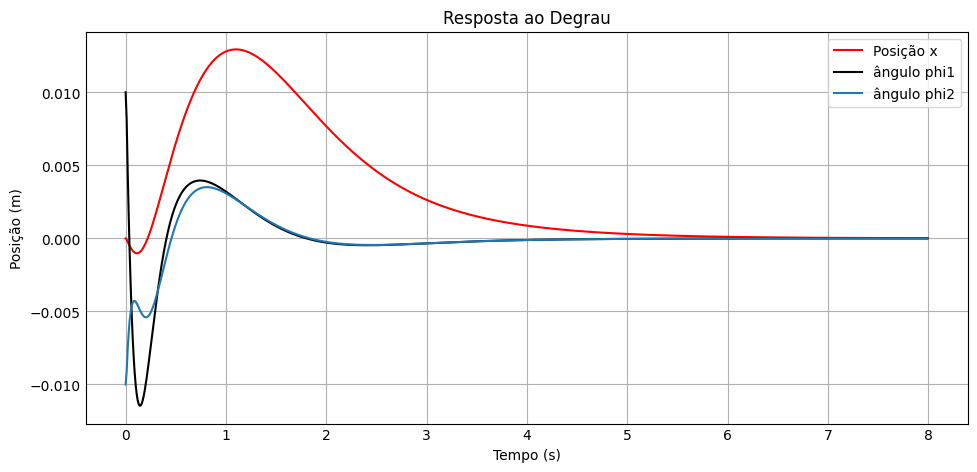

In [74]:
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,y[0],'-r', label='Posição x')
subplots[1].plot(t,y[1], '-k',label='ângulo phi1')
#subplots[1].stem(t,y[1], label='ângulo phi1')
subplots[1].plot(t,y[2], label='ângulo phi2')
#subplots[1].stem(t,y[2], label='ângulo phi2')
subplots[1].set_title('Resposta Inicial')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()

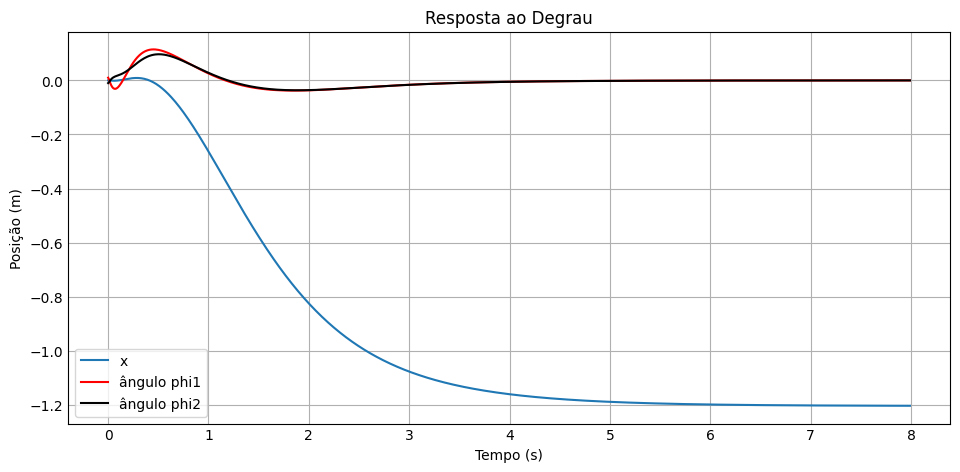

In [87]:
altura = 4
largura = 9
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t,p[0][0], label='x')
subplots[1].plot(s,p[1][0],'-r', label='ângulo phi1')
subplots[1].plot(s,p[2][0],'-k',label='ângulo phi2')
subplots[1].set_title('Resposta ao Degrau')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()

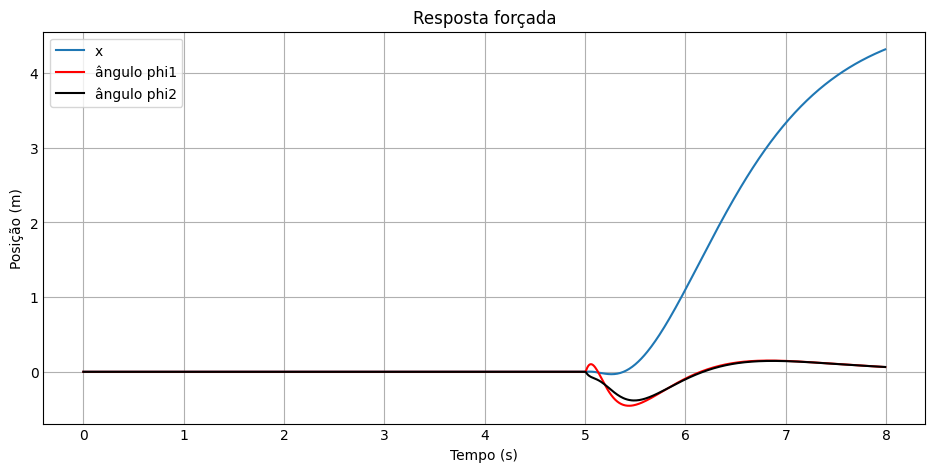

In [94]:
# Aplicando entrada 

# Definindo a função de entrada personalizada
def input_signal(t, t_entrada_apply, amplitude_pert):
    return amplitude_pert if t >= t_entrada_apply else 0

# Instante de tempo em que a entrada será aplicada
t_entrada_apply = 5

# Amplitude da entrada
amplitude_pert = 4
amplitude_pert = -4

# Aplicando a entrada
u = [input_signal(t_i, t_entrada_apply, amplitude_pert) for t_i in t]

# Calculando a resposta do sistema com a entrada aplicada
#t_out, y_out, w_out = ct.forced_response(Wip, T=t, U=u)
t_out, y_out= ct.forced_response(Wip, T=t, U=u)
# Plotando a saída
subplots = plt.subplots(1, 1, figsize=(largura, altura))
subplots[1].plot(t_out, y_out[0],label='x')
subplots[1].plot(t_out, y_out[1],'-r', label='ângulo phi1')
subplots[1].plot(t_out, y_out[2],'-k',label='ângulo phi2')
subplots[1].set_title('Resposta forçada')
subplots[1].set_xlabel('Tempo (s)')
subplots[1].set_ylabel('Posição (m)')
subplots[1].grid(True)
subplots[1].legend()
plt.show()